# skewed dataset CNN machine learning

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import numpy as np

Check gpu

In [2]:
#To determine if your system supports CUDA
print("==> Check devices..")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device: ",device)

#Also can print your current GPU id, and the number of GPUs you can use.
print("Our selected device: ", torch.cuda.current_device())
print(torch.cuda.device_count(), " GPUs is available")

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


Define transformation function

In [3]:
#The transform function for train data
transform_train = transforms.Compose([
    transforms.Resize(144),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

#The transform function for validation data
transform_validation = transforms.Compose([
    transforms.Resize(144),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

#The transform function for test data
transform_test = transforms.Compose([
    transforms.Resize(144),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Load dataset

In [4]:
#Use API to load train dataset
trainset = torchvision.datasets.ImageFolder(root = r'./training' ,transform=transform_train)

#Use API to load validation dataset
validationset = torchvision.datasets.ImageFolder(root = r'./validation' ,transform=transform_validation)

#Use API to load evaluation dataset
testset = torchvision.datasets.ImageFolder(root = r'./evaluation' ,transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=64, shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
classes = ('class0', 'class1', 'class10', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9')

Define Network

In [5]:
def reload_net():
    trainednet = models.vgg16_bn(pretrained=True)  
    trainednet.fc = torch.nn.Linear(1000, 11)  
    trainednet.fc = nn.Sequential(nn.Linear(1000,512),nn.LeakyReLU(),nn.Linear(512,256),nn.LeakyReLU(),nn.Linear(256,11))
    trainednet.load_state_dict(torch.load('./vgg16/34.pth'))
    return trainednet

In [6]:
# vgg16_bn
net = models.vgg16_bn(pretrained=True)
#net.fc = nn.Linear(1000, 11)
net.fc = nn.Sequential(nn.Linear(1000,512),nn.LeakyReLU(),nn.Linear(512,256),nn.LeakyReLU(),nn.Linear(256,11))
net = net.to(device) 
#print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [7]:
# Freeze parameters so we don't backprop through them
'''
for param in net.parameters():
    param.requires_grad = False

net.classifier = nn.Sequential(nn.Linear(25088,4096),
                               nn.LeakyReLU(),
                               nn.Linear(4096,512),
                               nn.LeakyReLU(),
                               nn.Linear(512,128),
                               nn.LeakyReLU(),
                               nn.Linear(128,11),
                              )
                              
#net.fc = nn.Linear(1000, 11)
net = net.to(device) 
print(net)
'''

'\nfor param in net.parameters():\n    param.requires_grad = False\n\nnet.classifier = nn.Sequential(nn.Linear(25088,4096),\n                               nn.LeakyReLU(),\n                               nn.Linear(4096,512),\n                               nn.LeakyReLU(),\n                               nn.Linear(512,128),\n                               nn.LeakyReLU(),\n                               nn.Linear(128,11),\n                              )\n                              \n#net.fc = nn.Linear(1000, 11)\nnet = net.to(device) \nprint(net)\n'

Ignore warning

In [7]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

Define criterion and Optimize

In [8]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() #定義損失函數
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=[0.9, 0.999]) #定優化函數
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)

Train

In [12]:
net.train()
num_epoch = 200
run_epoch = 0
t_loss = []
v_loss = []
training_accuracy = []
validation_accuracy = []
total = 0

for epoch in range(200):  # loop over the dataset multiple times
    train_loss = 0.0
    validation_loss = 0.0
    test_loss = 0.0
    correct_train = 0
    correct_validation = 0
    correct_test = 0
    train_num = 0
    val_num = 0
    test_num = 0
    cls = []

    for i in range(11):
        cls.append(0)
    
    ########################
    # train the model      #
    ########################
    
    net.train()
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        #change the type into cuda tensor 
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # select the class with highest probability
        _, pred = outputs.max(1)
        # if the model predicts the same results as the true
        # label, then the correct counter will plus 1
        correct_train += pred.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_loss += loss.item()
        train_num += 1
   

        
    ########################
    # validate the model   #
    ########################
    
    net.eval()
    for i, (inputs, labels) in enumerate(validationloader, 0):
        # move tensors to GPU if CUDA is available
        inputs = inputs.to(device) 
        labels = labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = net(inputs)
        _, pred = outputs.max(1)
        correct_validation += pred.eq(labels).sum().item()
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # update average validation loss 
        validation_loss += loss.item()
        val_num += 1
        
    ########################
    # evaluate the model   #
    ########################
    

    for i, (inputs, labels) in enumerate(testloader, 0):
        # move tensors to GPU if CUDA is available
        inputs = inputs.to(device) 
        labels = labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = net(inputs)
        _, pred = outputs.max(1)
        correct_test += pred.eq(labels).sum().item()
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # update average validation loss 
        test_loss += loss.item()
        test_num += 1
        total += labels.size(0)

        cls[0] += (pred.eq(0) * pred.eq(labels)).sum().item()
        cls[1] += (pred.eq(1) * pred.eq(labels)).sum().item()
        cls[2] += (pred.eq(2) * pred.eq(labels)).sum().item()
        cls[3] += (pred.eq(3) * pred.eq(labels)).sum().item()
        cls[4] += (pred.eq(4) * pred.eq(labels)).sum().item()
        cls[5] += (pred.eq(5) * pred.eq(labels)).sum().item()
        cls[6] += (pred.eq(6) * pred.eq(labels)).sum().item()
        cls[7] += (pred.eq(7) * pred.eq(labels)).sum().item()
        cls[8] += (pred.eq(8) * pred.eq(labels)).sum().item()
        cls[9] += (pred.eq(9) * pred.eq(labels)).sum().item()
        cls[10] += (pred.eq(10) * pred.eq(labels)).sum().item()
        
    if epoch % 1 == 0:    # print every 200 mini-batches
        print('[%d, %5d] train_loss: %.3f' % (epoch + 1, num_epoch, train_loss / train_num))
        print('[%d, %5d] validation_loss: %.3f' % (epoch + 1, num_epoch, validation_loss / val_num))
        print('[%d, %5d] evaluation_loss: %.3f' % (epoch + 1, num_epoch, test_loss / test_num))
        print('%d epoch, training accuracy: %.4f' % (epoch + 1, correct_train / len(trainset)))
        print('%d epoch, validation accuracy: %.4f' % (epoch + 1, correct_validation / len(validationset)))
        print('%d epoch, evaluation accuracy: %.4f' % (epoch + 1, correct_test / len(testset)))
        print('Class 0 : %d/%d    %10f%%' % (cls[0], 368, cls[0]/368))
        print('Class 1 : %d/%d    %10f%%' % (cls[1], 148, cls[1]/148))
        print('Class 2 : %d/%d    %10f%%' % (cls[2], 500, cls[2]/500))
        print('Class 3 : %d/%d    %10f%%' % (cls[3], 335, cls[3]/335))
        print('Class 4 : %d/%d    %10f%%' % (cls[4], 287, cls[4]/287))
        print('Class 5 : %d/%d    %10f%%' % (cls[5], 432, cls[5]/432))
        print('Class 6 : %d/%d    %10f%%' % (cls[6], 147, cls[6]/147))
        print('Class 7 : %d/%d    %10f%%' % (cls[7], 96, cls[7]/96))
        print('Class 8 : %d/%d    %10f%%' % (cls[8], 303, cls[8]/303))
        print('Class 9 : %d/%d    %10f%%' % (cls[9], 500, cls[9]/500))
        print('Class 10 : %d/%d    %10f%%' % (cls[10], 231, cls[10]/231))
        print(total)
        print('-----------------------------------------')
        
        t_loss.append(train_loss / train_num)
        v_loss.append(test_loss / test_num)
        training_accuracy.append(correct_train / len(trainset))
        validation_accuracy.append(correct_validation / len(validationset))
        running_loss = 0.0
        validation_loss = 0.0
        test_loss = 0.0
        train_num = 0
        val_num = 0
        test_num = 0
        correct_train = 0
        correct_validation = 0
        correct_test = 0
        total = 0
        run_epoch += 1
        
        for i in range(11):
            cls[i] = 0
        torch.save(net.state_dict(), './vgg16/' + str(epoch) + '.pth')
    
print('Finished Training')

[1,   200] train_loss: 0.962
[1,   200] validation_loss: 1.212
[1,   200] evaluation_loss: 1.101
1 epoch, training accuracy: 0.6965
1 epoch, validation accuracy: 0.6242
1 epoch, evaluation accuracy: 0.6534
Class 0 : 79/368      0.214674%
Class 1 : 101/148      0.682432%
Class 2 : 175/500      0.350000%
Class 3 : 374/335      1.116418%
Class 4 : 191/287      0.665505%
Class 5 : 132/432      0.305556%
Class 6 : 349/147      2.374150%
Class 7 : 85/96      0.885417%
Class 8 : 66/303      0.217822%
Class 9 : 193/500      0.386000%
Class 10 : 442/231      1.913420%
3347
-----------------------------------------
[2,   200] train_loss: 0.855
[2,   200] validation_loss: 0.906
[2,   200] evaluation_loss: 0.838
2 epoch, training accuracy: 0.7298
2 epoch, validation accuracy: 0.7117
2 epoch, evaluation accuracy: 0.7293
Class 0 : 199/368      0.540761%
Class 1 : 108/148      0.729730%
Class 2 : 201/500      0.402000%
Class 3 : 213/335      0.635821%
Class 4 : 204/287      0.710801%
Class 5 : 245/43

KeyboardInterrupt: 

Test and validation

In [89]:
pretrain_net = reload_net().to(device)
test_loss = 0.0
correct_test = 0
test_num = 0
cls = np.zeros(11)
correct_top3 = 0

In [90]:
pretrain_net.eval()
for i, (inputs, labels) in enumerate(testloader, 0):
    # move tensors to GPU if CUDA is available
    inputs = inputs.to(device) 
    labels = labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    outputs = pretrain_net(inputs)
    _, pred = outputs.max(1)
    correct_test += pred.eq(labels).sum().item()
    _, top3 = outputs.topk(3)
    correct_top3 += top3.eq(labels.view(-1,1).expand_as(top3)).sum().item()
    
    cls[0] += (pred.eq(0) * pred.eq(labels)).sum().item()
    cls[1] += (pred.eq(1) * pred.eq(labels)).sum().item()
    cls[2] += (pred.eq(2) * pred.eq(labels)).sum().item()
    cls[3] += (pred.eq(3) * pred.eq(labels)).sum().item()
    cls[4] += (pred.eq(4) * pred.eq(labels)).sum().item()
    cls[5] += (pred.eq(5) * pred.eq(labels)).sum().item()
    cls[6] += (pred.eq(6) * pred.eq(labels)).sum().item()
    cls[7] += (pred.eq(7) * pred.eq(labels)).sum().item()
    cls[8] += (pred.eq(8) * pred.eq(labels)).sum().item()
    cls[9] += (pred.eq(9) * pred.eq(labels)).sum().item()
    cls[10] += (pred.eq(10) * pred.eq(labels)).sum().item()

/home/s1041549/anaconda3/envs/dlsystem/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (91049764 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


This class is not correspond the cls index. For example class 9 is in cls[10].

In [93]:
print('Test set: Top 1 Accuracy: %d/3347 (%.2f%%), Top 3 Accuracy: %d/3347 (%.2f%%)' 
      % (correct_test, correct_test / len(testset)*100, correct_top3, correct_top3/ len(testset)*100))
print('Class 0 : %d/%d    %10f%%' % (cls[0], 368, cls[0]/368))
print('Class 1 : %d/%d    %10f%%' % (cls[1], 148, cls[1]/148))
print('Class 2 : %d/%d    %10f%%' % (cls[3], 500, cls[3]/500))
print('Class 3 : %d/%d    %10f%%' % (cls[4], 335, cls[4]/335))
print('Class 4 : %d/%d    %10f%%' % (cls[5], 287, cls[5]/287))
print('Class 5 : %d/%d    %10f%%' % (cls[6], 432, cls[6]/432))
print('Class 6 : %d/%d    %10f%%' % (cls[7], 147, cls[7]/147))
print('Class 7 : %d/%d    %10f%%' % (cls[8], 96, cls[8]/96))
print('Class 8 : %d/%d    %10f%%' % (cls[9], 303, cls[9]/303))
print('Class 9 : %d/%d    %10f%%' % (cls[10], 500, cls[10]/500))
print('Class 10 : %d/%d    %10f%%' % (cls[2], 231, cls[2]/231))
print('-----------------------------------------')

Test set: Top 1 Accuracy: 2795/3347 (83.51%), Top 3 Accuracy: 3200/3347 (95.61%)
Class 0 : 302/368      0.820652%
Class 1 : 101/148      0.682432%
Class 2 : 349/500      0.698000%
Class 3 : 271/335      0.808955%
Class 4 : 254/287      0.885017%
Class 5 : 359/432      0.831019%
Class 6 : 142/147      0.965986%
Class 7 : 86/96      0.895833%
Class 8 : 252/303      0.831683%
Class 9 : 476/500      0.952000%
Class 10 : 203/231      0.878788%
-----------------------------------------


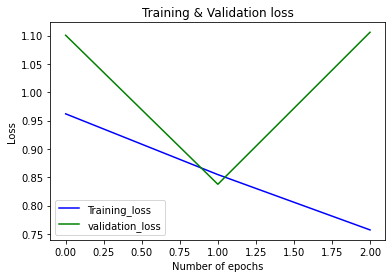

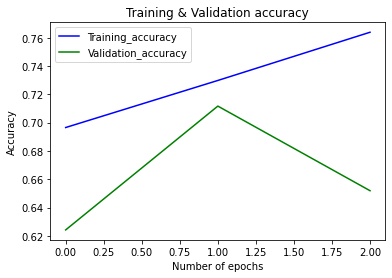

In [18]:
# visualization
import matplotlib.pyplot as plt

plt.plot(range(run_epoch), t_loss, 'b-', label='Training_loss')
plt.plot(range(run_epoch), v_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(run_epoch), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(run_epoch), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
[range(2)]

[range(0, 2)]